In [98]:
import numpy as np
import torch
import gym
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal

class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma = .9, batch_size = 20, epsilon = .2, pi_lr=1e-4, v_lr=1e-4, epoch_n = 30):
        super().__init__()
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 64), nn.ReLU(), 
                                      nn.Linear(64, 2 * action_dim), nn.Tanh()) 
        #умн на 2 т.к. половина пойдет на предсказ-е мат.ож-я, а половина на дисперсии, 
        #tanh тк ограничиваем зн-я от -1 до 1
        self.v_model = nn.Sequential(nn.Linear(state_dim, 64), nn.ReLU(), nn.Linear(64, 1))
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr = pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr = v_lr)
    
    def get_action(self, state):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, torch.exp(log_std))
        
        action = dist.sample()
        return action.numpy().reshape(1) #reshape makes an array. without - a digit
        
    def fit(self, states, actions, rewards, dones):
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)
        
        returns  = np.zeros(rewards.shape) #это Gt
        returns[-1] = rewards[-1]        
        for t in range(rewards.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]
            #print(t+1, returns[t+1], rewards[t+1], dones[t+1])
            
        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])  
        
        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1) , log_std.unsqueeze(1) 
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()
        
        for epoch in range(self.epoch_n):
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i:i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]

                b_advantage = -self.v_model(b_states) + b_returns.detach()

                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1) , b_log_std.unsqueeze(1) 
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)

                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs) #экспонента от разности 2х логарифмов - это дробь
                #это лучше, чем брать эксп от 1 и делить на эксп от другого

                pi_loss1 = b_ratio * b_advantage.detach()
                pi_loss2 = torch.clamp(b_ratio, 1-self.epsilon, 1+self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss1, pi_loss2))


                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()

                v_loss = torch.mean(b_advantage ** 2)


                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()


In [99]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

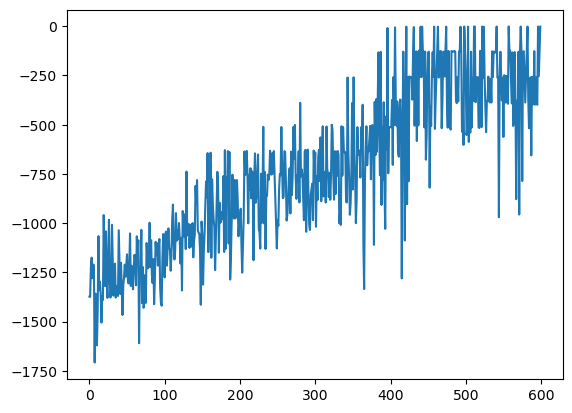

In [101]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPO(state_dim, action_dim)
action = agent.get_action(np.array(state_dim))

episode_n = 30
trajectory_n = 20

total_rewards = []

for episode in range(episode_n):
    states, actions, rewards, dones = [], [], [], []
    
    for _ in range(trajectory_n):
        total_reward = 0
        state = env.reset()
        
        for t in range(200):
            states.append(state)
            
            action = agent.get_action(state)
            actions.append(action)

            state, reward, done, _ = env.step(2 * action)
            rewards.append(reward)
            dones.append(done)
            
            total_reward += reward
        total_rewards.append(total_reward)
    agent.fit(states, actions, rewards, dones)

plt.plot(total_rewards)